In [1]:
# Importations nécessaires
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression  # Utilisé comme base pour KNN custom
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, col, broadcast
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install findspark
import findspark
findspark.init()
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 8g pyspark-shell"

In [3]:
# Créer une session spark et tester avec un message hello spark
spark = SparkSession.builder.appName("KNN_Regression").config("spark.sql.adaptive.enabled", "true").config("spark.sql.adaptive.coalescePartitions.enabled", "true").getOrCreate()
df = spark.sql("select 'spark KNN' as hello")
df.show()

+---------+
|    hello|
+---------+
|spark KNN|
+---------+



In [4]:
print("📂 Chargement des données King County...")
df = spark.read.csv("kc_house_data.csv", header=True, inferSchema=True)

📂 Chargement des données King County...


In [5]:
# Aperçu des données
print("📊 Aperçu des données :")
print(f"Nombre d'observations : {df.count():,}")
print(f"Nombre de variables : {len(df.columns)}")
print("\n" + "="*60)

📊 Aperçu des données :
Nombre d'observations : 21,613
Nombre de variables : 21



In [6]:
# Affichage des premières lignes
print("🔍 Premières observations :")
df.show(5)

🔍 Premières observations :
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7| 

In [7]:
# Informations sur les colonnes
print("\n📋 Structure des données :")
print("Colonnes disponibles :")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


📋 Structure des données :
Colonnes disponibles :
 1. id
 2. date
 3. price
 4. bedrooms
 5. bathrooms
 6. sqft_living
 7. sqft_lot
 8. floors
 9. waterfront
10. view
11. condition
12. grade
13. sqft_above
14. sqft_basement
15. yr_built
16. yr_renovated
17. zipcode
18. lat
19. long
20. sqft_living15
21. sqft_lot15


In [8]:
# Informations sur les types
df.printSchema()
print("\n📈 Statistiques descriptives:")
df.describe().show()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)


📈 Statistiques descriptives:
+-------+--------------------+---------------+------------------+-----------------+------------------+-----------------

#2. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)

In [9]:
# Vérification des valeurs manquantes
print("🔍 Valeurs manquantes par colonne:")
import pyspark.sql.functions as F

df.select([F.count(F.when(F.col(column_name).isNull(), F.lit(1))).alias(column_name) for column_name in df.columns]).show()

🔍 Valeurs manquantes par colonne:
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
| id|date|price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat|long|sqft_living15|sqft_lot15|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
|  0|   0|    0|       0|        0|          0|       0|     0|         0|   0|        0|    0|         0|            0|       0|           0|      0|  0|   0|            0|         0|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+



In [10]:
# Vérification des doublons
duplicates = df.count() - df.dropDuplicates().count()
print(f"\n🔄 Nombre de doublons : {duplicates}")
if duplicates > 0:
    df = df.dropDuplicates()
    print(f"✅ {duplicates} doublons supprimés")


🔄 Nombre de doublons : 0


In [11]:
# Conversion pour visualisations
df_pandas = df.toPandas()

#3. ANALYSE DE CORRÉLATION APPROFONDIE

In [12]:
# Variables numériques pour l'analyse
numeric_cols = ['price', 'sqft_living15', 'view', 'lat', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'grade', 'sqft_above', 'sqft_basement', 'waterfront', 'yr_renovated', 'sqft_lot15', 'condition', 'id', 'long', 'zipcode', 'yr_built']
numeric_cols = [col for col in numeric_cols if col in df_pandas.columns]

In [13]:
# Corrélations avec le prix (triées par importance)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import builtins

In [14]:
# Assemble features into a vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df).select("features")

In [15]:
# Calculate correlation matrix
matrix = Correlation.corr(df_vector, "features").head()
correlation_matrix = matrix[0].toArray()


In [16]:
# Create a mapping of column indices to names
col_mapping = {i: col_name for i, col_name in enumerate(numeric_cols)}


In [17]:
# Find price column index
price_index = numeric_cols.index('price')

In [18]:
# Extract correlations with price
print("\n🏠 Corrélations avec le prix:")
price_correlations = []
for i, corr_val in enumerate(correlation_matrix[price_index]):
    if i != price_index:
        price_correlations.append((col_mapping[i], float(corr_val)))
# Sort by correlation value
price_correlations.sort(key=lambda x: x[1], reverse=True)
# Display results
for var, corr_val in price_correlations:
    print(f"{var:15s}: {corr_val:.3f}")


🏠 Corrélations avec le prix:
sqft_living    : 0.702
grade          : 0.667
sqft_above     : 0.606
sqft_living15  : 0.585
bathrooms      : 0.525
view           : 0.397
sqft_basement  : 0.324
bedrooms       : 0.308
lat            : 0.307
waterfront     : 0.266
floors         : 0.257
yr_renovated   : 0.126
sqft_lot       : 0.090
sqft_lot15     : 0.082
yr_built       : 0.054
condition      : 0.036
long           : 0.022
id             : -0.017
zipcode        : -0.053


In [19]:
# Détection de multicolinéarité
print("\n⚠️  Multicolinéarité détectée (|r| > 0.8):")
high_corr_pairs = []

for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        var1, var2 = numeric_cols[i], numeric_cols[j]
        corr_val = float(correlation_matrix[i, j])
        if builtins.abs(corr_val) > 0.8:
            high_corr_pairs.append((var1, var2, corr_val))
            print(f"{var1:15s} ↔ {var2:15s}: {corr_val:.3f}")

if not high_corr_pairs:
    print("    ✅ Aucune multicolinéarité critique détectée")


⚠️  Multicolinéarité détectée (|r| > 0.8):
sqft_living     ↔ sqft_above     : 0.877


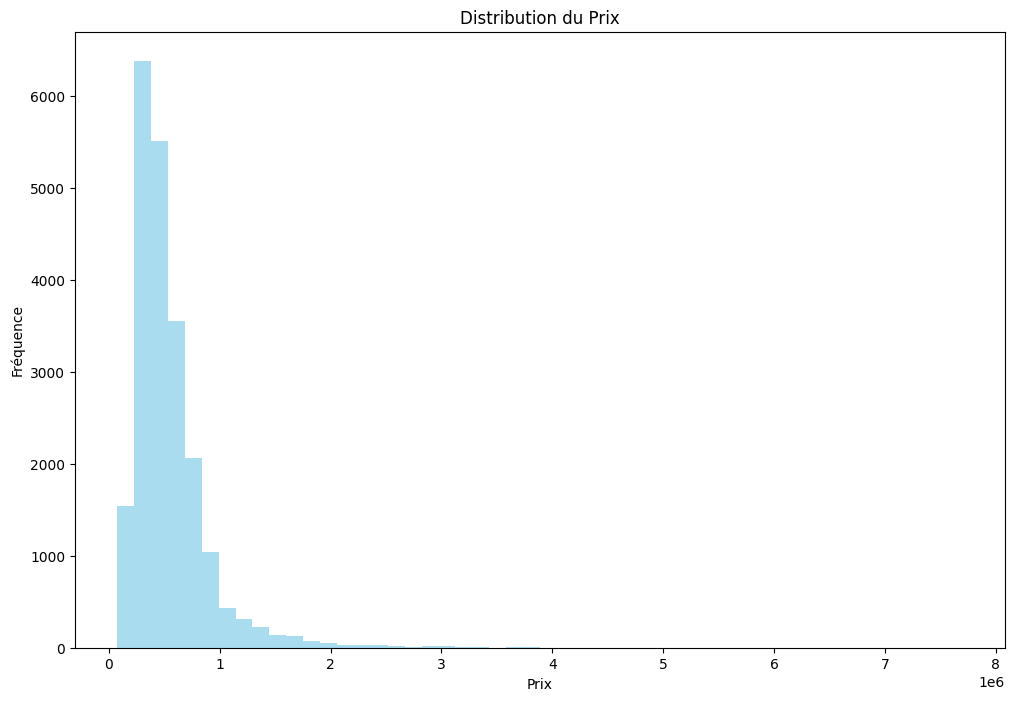

In [20]:
# Visualisations complètes
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Distribution du prix
plt.figure()
plt.hist(df_pandas['price'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution du Prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0, 0.5, 'price'),
  Text(0, 1.5, 'sqft_living15'),
  Text(0, 2.5, 'view'),
  Text(0, 3.5, 'lat'),
  Text(0, 4.5, 'bedrooms'),
  Text(0, 5.5, 'bathrooms'),
  Text(0, 6.5, 'sqft_living'),
  Text(0, 7.5, 'sqft_lot'),
  Text(0, 8.5, 'floors'),
  Text(0, 9.5, 'grade'),
  Text(0, 10.5, 'sqft_above'),
  Text(0, 11.5, 'sqft_basement'),
  Text(0, 12.5, 'waterfront'),
  Text(0, 13.5, 'yr_renovated'),
  Text(0, 14.5, 'sqft_lot15'),
  Text(0, 15.5, 'condition'),
  Text(0, 16.5, 'id'),
  Text(0, 17.5, 'long'),
  Text(0, 18.5, 'zipcode'),
  Text(0, 19.5, 'yr_built')])

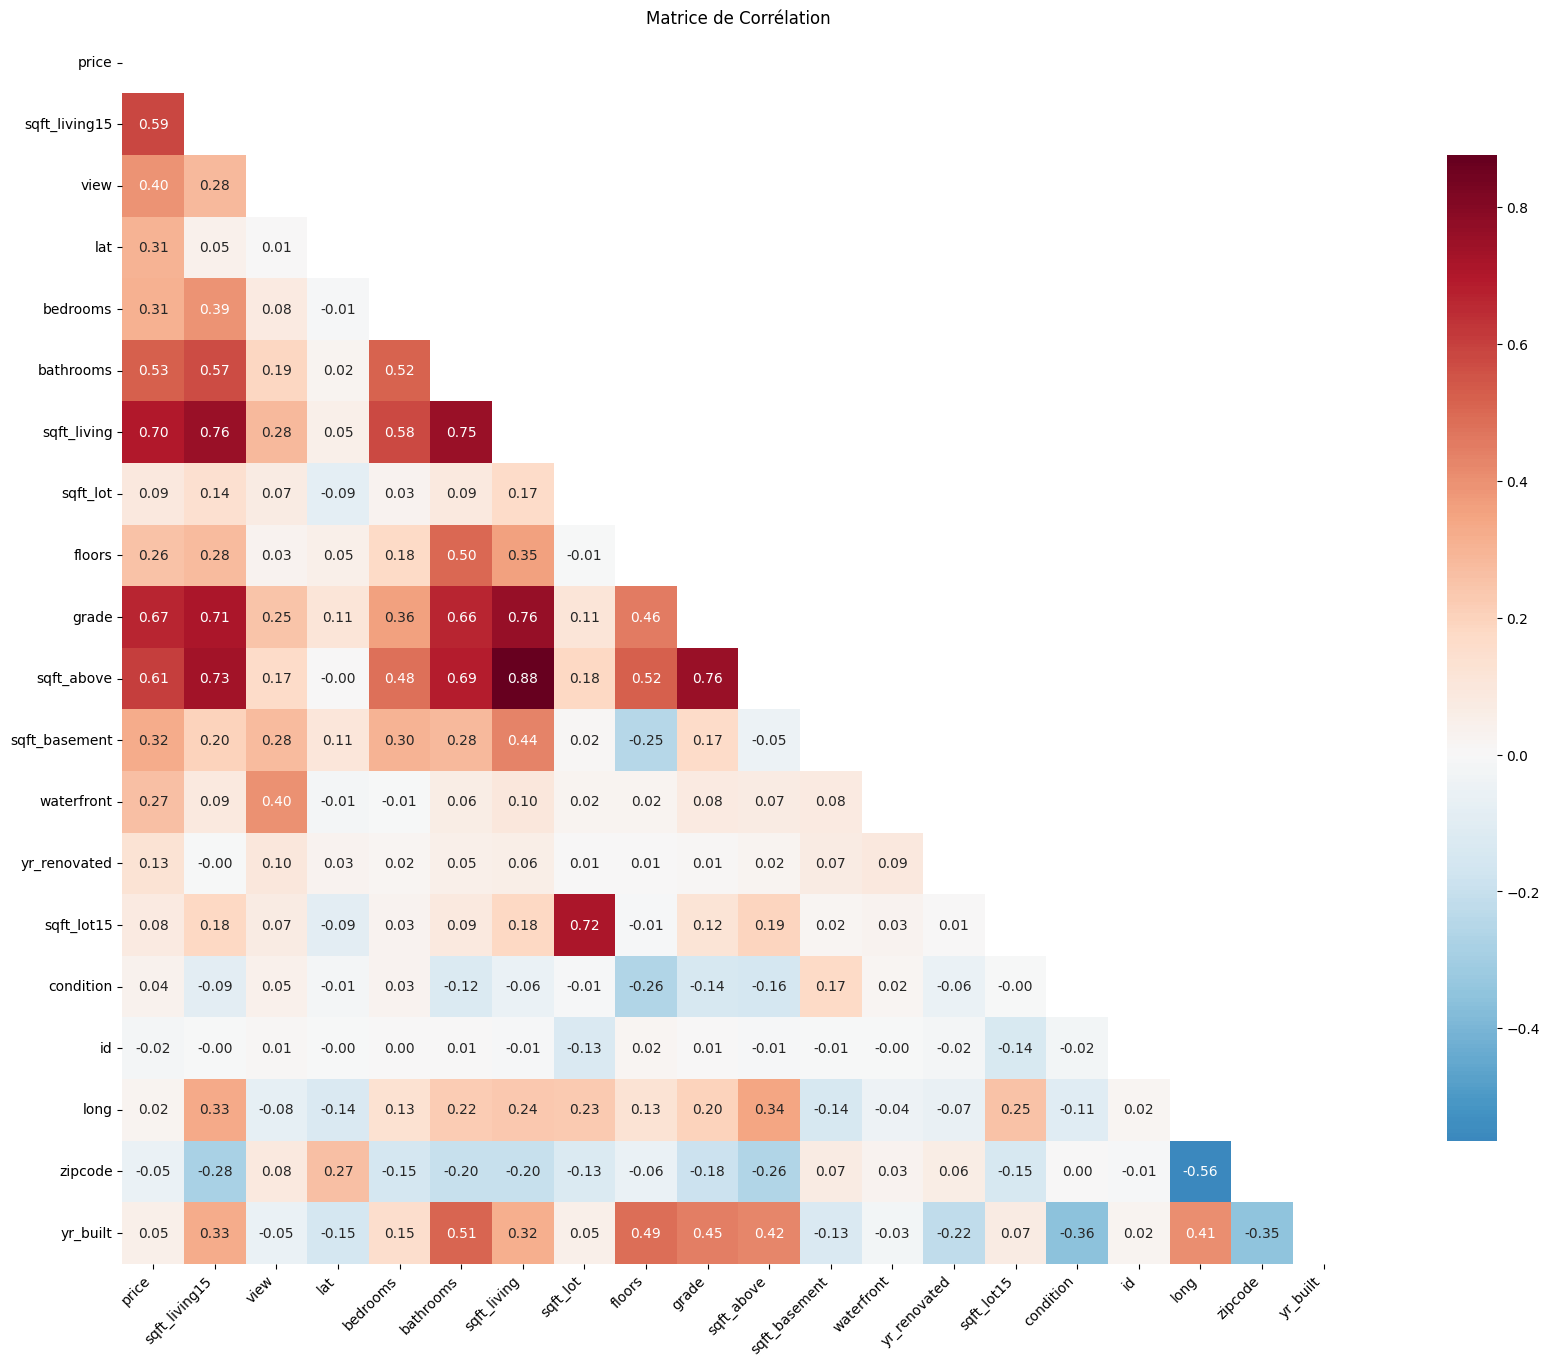

In [21]:
# 2. Matrice de corrélation complète
plt.rcParams['figure.figsize'] = (24, 16)  # largeur, hauteur en pouces
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Créer la heatmap avec les noms des colonnes
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            xticklabels=numeric_cols,  # Noms des colonnes
            yticklabels=numeric_cols)  # Noms des lignes

plt.title('Matrice de Corrélation')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

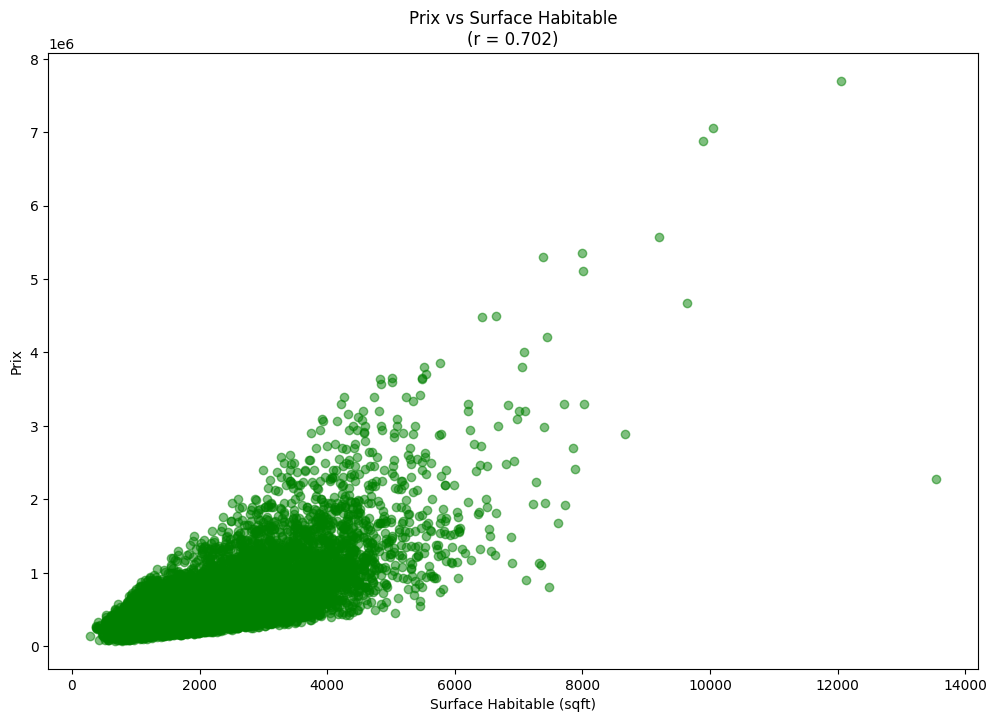

In [22]:
# 3. Prix vs Surface Habitable
plt.rcParams['figure.figsize'] = (12, 8)
plt.figure()
plt.scatter(df_pandas['sqft_living'], df_pandas['price'], alpha=0.5, color='green')
correlation_coeff = df_pandas['price'].corr(df_pandas['sqft_living'])
plt.title(f'Prix vs Surface Habitable\n(r = {correlation_coeff:.3f})')
plt.xlabel('Surface Habitable (sqft)')
plt.ylabel('Prix')
plt.show()

#4. PRÉTRAITEMENT DES DONNÉES

In [23]:
# 1. Colonnes évidentes à supprimer
colonnes_evidentes = ['id', 'date']

In [24]:
# 2. Analyse des corrélations pour identifier les colonnes faiblement corrélées
df_temp = df.toPandas()
numeric_columns = df_temp.select_dtypes(include=[np.number]).columns
correlation_matrix_pandas = df_temp[numeric_columns].corr()
price_correlations_pandas = correlation_matrix_pandas['price'].abs() if 'price' in correlation_matrix_pandas.columns else pd.Series()

In [25]:
# 3. Colonnes avec très faible corrélation
SEUIL_CORRELATION = 0.2
colonnes_faible_corr = []

if not price_correlations_pandas.empty:
    for col_name, corr in price_correlations_pandas.items():
        if col_name != 'price' and corr < SEUIL_CORRELATION:
            colonnes_faible_corr.append(col_name)

In [26]:
# 4. Liste complète des colonnes à supprimer
colonnes_a_supprimer = []
for col_name in colonnes_evidentes:
    if col_name in df.columns:
        colonnes_a_supprimer.append(col_name)

for col_name in colonnes_faible_corr:
    if col_name in df.columns:
        colonnes_a_supprimer.append(col_name)

colonnes_a_supprimer = list(set(colonnes_a_supprimer))

print(f"\n📊 ANALYSE DES SUPPRESSIONS:")
print(f"   Colonnes évidentes à supprimer: {[col for col in colonnes_evidentes if col in df.columns]}")
print(f"   Colonnes faible corrélation (< {SEUIL_CORRELATION}): {colonnes_faible_corr}")
print(f"   TOTAL à supprimer: {len(colonnes_a_supprimer)} colonnes")


📊 ANALYSE DES SUPPRESSIONS:
   Colonnes évidentes à supprimer: ['id', 'date']
   Colonnes faible corrélation (< 0.2): ['id', 'sqft_lot', 'condition', 'yr_built', 'yr_renovated', 'zipcode', 'long', 'sqft_lot15']
   TOTAL à supprimer: 9 colonnes


In [27]:
# Application de la suppression
if colonnes_a_supprimer:
    df_clean = df.drop(*colonnes_a_supprimer)
    print(f"\n✅ {len(colonnes_a_supprimer)} colonnes supprimées: {colonnes_a_supprimer}")
else:
    df_clean = df
    print(f"\n✅ Aucune colonne à supprimer selon les critères")

print(f"📊 Colonnes restantes: {len(df_clean.columns)} (était {len(df.columns)})")


✅ 9 colonnes supprimées: ['long', 'id', 'condition', 'zipcode', 'sqft_lot15', 'sqft_lot', 'yr_renovated', 'date', 'yr_built']
📊 Colonnes restantes: 12 (était 21)


In [28]:
# Détection et traitement des outliers (méthode IQR)
def detect_outliers(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [29]:
# Traitement des outliers pour les colonnes numériques importantes
colonnes_numeriques = ['price', 'grade', 'sqft_living15', 'sqft_living', 'bathrooms',
                       'view', 'bedrooms', 'lat', 'waterfront', 'floors',
                       'sqft_above', 'sqft_basement',]

for column_name in colonnes_numeriques:
    if column_name in df_clean.columns:
        lower, upper = detect_outliers(df_clean, column_name)
        count_before = df_clean.count()
        df_clean = df_clean.filter((col(column_name) >= lower) & (col(column_name) <= upper))
        count_after = df_clean.count()
        print(f"📊 {column_name}: {count_before - count_after} outliers supprimés")

📊 price: 1182 outliers supprimés
📊 grade: 1174 outliers supprimés
📊 sqft_living15: 257 outliers supprimés
📊 sqft_living: 189 outliers supprimés
📊 bathrooms: 34 outliers supprimés
📊 view: 1317 outliers supprimés
📊 bedrooms: 323 outliers supprimés
📊 lat: 0 outliers supprimés
📊 waterfront: 0 outliers supprimés
📊 floors: 0 outliers supprimés
📊 sqft_above: 401 outliers supprimés
📊 sqft_basement: 475 outliers supprimés


In [30]:
# Feature Engineering spécialement optimisé pour KNN
print("\n🔧 FEATURE ENGINEERING POUR KNN")

# 1. Prix par pied carré (très importante pour l'immobilier)
df_clean = df_clean.withColumn("price_per_sqft", col("price") / col("sqft_living"))

# 2. Total des pièces
df_clean = df_clean.withColumn("total_rooms", col("bedrooms") + col("bathrooms"))

# 3. Supprimer la feature de rénovation puisque yr_renovated n'existe pas
# df_clean = df_clean.withColumn("years_since_renovation", ...) # SUPPRIMÉ

# 4. Indicateur de rénovation
df_clean = df_clean.withColumn("has_basement", when(col("sqft_basement") > 0, 1).otherwise(0))

# 5. Ratio sous-sol/surface habitable
df_clean = df_clean.withColumn("basement_ratio",
                               when(col("sqft_living") > 0, col("sqft_basement") / col("sqft_living"))
                               .otherwise(0))

# 6. Vérification des nouvelles colonnes
print("Nouvelles features créées:")
new_features = ["price_per_sqft", "total_rooms", "has_basement", "basement_ratio"]
for feature in new_features:
    count_before = df_clean.count()
    df_clean_temp = df_clean.filter(col(feature).isNotNull() &
                                   ~isnan(col(feature)) &
                                   (col(feature) != float('inf')) &
                                   (col(feature) != float('-inf')))
    count_after = df_clean_temp.count()
    print(f"📊 {feature}: {count_before - count_after} valeurs problématiques supprimées")

# Appliquer le nettoyage final
df_clean = df_clean.filter(col("price_per_sqft").isNotNull() &
                          ~isnan(col("price_per_sqft")) &
                          (col("price_per_sqft") != float('inf')) &
                          (col("price_per_sqft") != float('-inf')))

print(f"Dataset final: {df_clean.count()} lignes")


🔧 FEATURE ENGINEERING POUR KNN
Nouvelles features créées:
📊 price_per_sqft: 0 valeurs problématiques supprimées
📊 total_rooms: 0 valeurs problématiques supprimées
📊 has_basement: 0 valeurs problématiques supprimées
📊 basement_ratio: 0 valeurs problématiques supprimées
Dataset final: 16261 lignes


In [31]:
# Transformation logarithmique du prix pour normaliser
df_clean = df_clean.withColumn("log_price", log(col("price")))

In [32]:
# Variables dérivées spécifiques pour KNN
df_clean = df_clean.withColumn("bathroom_bedroom_ratio",
                               when(col("bedrooms") > 0, col("bathrooms") / col("bedrooms"))
                               .otherwise(col("bathrooms")))
# 6. Transformation logarithmique du prix (améliore souvent les performances KNN)
df_clean = df_clean.withColumn("log_price", log(col("price")))

print("✅ Features créées: price_per_sqft, total_rooms, has_basement, basement_ratio, bathroom_bedroom_ratio, log_price")

# Vérification des valeurs infinies/nulles
print("\n🔍 Vérification de la qualité des données:")
df_clean.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in
                ["price_per_sqft", "total_rooms", "has_basement", "basement_ratio", "bathroom_bedroom_ratio", "log_price"]]).show()

print("✅ Nouvelles variables créées: price_par_sqft, total_rooms, has_basement, basement_ratio, bathroom_bedroom_ratio")

✅ Features créées: price_per_sqft, total_rooms, has_basement, basement_ratio, bathroom_bedroom_ratio, log_price

🔍 Vérification de la qualité des données:
+--------------+-----------+------------+--------------+----------------------+---------+
|price_per_sqft|total_rooms|has_basement|basement_ratio|bathroom_bedroom_ratio|log_price|
+--------------+-----------+------------+--------------+----------------------+---------+
|             0|          0|           0|             0|                     0|        0|
+--------------+-----------+------------+--------------+----------------------+---------+

✅ Nouvelles variables créées: price_par_sqft, total_rooms, has_basement, basement_ratio, bathroom_bedroom_ratio


In [33]:
# Sélection finale des features pour le machine learning
feature_cols = [col_name for col_name in df_clean.columns
                if col_name not in ['price', 'log_price']]

print(f"\n🎯 FEATURES POUR LE MACHINE LEARNING KNN:")
print(f"   Variables disponibles: {len(feature_cols)}")
print(f"   Liste: {feature_cols}")


🎯 FEATURES POUR LE MACHINE LEARNING KNN:
   Variables disponibles: 16
   Liste: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15', 'price_per_sqft', 'total_rooms', 'has_basement', 'basement_ratio', 'bathroom_bedroom_ratio']


#5. PRÉPARATION POUR LE MACHINE LEARNING KNN

In [34]:
# Assemblage des features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [35]:
# Normalisation des features (CRITIQUE pour KNN)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True  # Important pour KNN
)


In [36]:
# Application des transformations
df_assembled = assembler.transform(df_clean)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [37]:
# Division train/test (80/20)
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)
print(f"📊 Données d'entraînement: {train_df.count()} échantillons")
print(f"📊 Données de test: {test_df.count()} échantillons")

📊 Données d'entraînement: 13082 échantillons
📊 Données de test: 3179 échantillons


#6. IMPLÉMENTATION KNN POUR PYSPARK

In [38]:
# Utilisation de sklearn pour des échantillons plus petits
def knn_with_sklearn(train_df, test_df, k_values=[3, 5, 7, 10, 15]):
    """Implémentation KNN avec sklearn pour validation croisée"""

    # Conversion en pandas pour sklearn
    train_pandas = train_df.select("scaled_features", "price").toPandas()
    test_pandas = test_df.select("scaled_features", "price").toPandas()

    # Extraction des features
    X_train = np.array([row.toArray() for row in train_pandas['scaled_features']])
    y_train = train_pandas['price'].values
    X_test = np.array([row.toArray() for row in test_pandas['scaled_features']])
    y_test = test_pandas['price'].values

    best_k = None
    best_score = float('inf')
    results = {}

    print("🔍 Optimisation de k pour KNN:")

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)

        # Prédictions
        y_pred = knn.predict(X_test)

        # Métriques
        rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
        mae = np.mean(np.abs(y_test - y_pred))
        r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

        results[k] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'model': knn,
            'predictions': y_pred
        }

        print(f"   k={k:2d}: RMSE=${rmse:,.0f}, R²={r2:.4f}, MAE=${mae:,.0f}")

        if rmse < best_score:
            best_score = rmse
            best_k = k

    return results, best_k

#7. ENTRAÎNEMENT ET OPTIMISATION KNN

In [39]:
print("⚙️  Démarrage de l'optimisation KNN...")

⚙️  Démarrage de l'optimisation KNN...


In [40]:
# Échantillonnage pour accélérer le processus (KNN peut être lent sur gros datasets)
sample_fraction = 0.3  # 30% des données pour l'optimisation
train_sample = train_df.sample(sample_fraction, seed=42)
test_sample = test_df.sample(sample_fraction, seed=42)

print(f"📊 Échantillon d'entraînement: {train_sample.count()} échantillons")
print(f"📊 Échantillon de test: {test_sample.count()} échantillons")

📊 Échantillon d'entraînement: 4044 échantillons
📊 Échantillon de test: 984 échantillons


In [41]:
# Optimisation avec sklearn
results, best_k = knn_with_sklearn(train_sample, test_sample)

print(f"\n✅ Optimisation terminée!")
print(f"🎯 Meilleur k: {best_k}")
print(f"🎯 Meilleure performance: RMSE=${results[best_k]['rmse']:,.0f}")

🔍 Optimisation de k pour KNN:
   k= 3: RMSE=$66,022, R²=0.8594, MAE=$45,607
   k= 5: RMSE=$63,818, R²=0.8686, MAE=$43,887
   k= 7: RMSE=$63,720, R²=0.8690, MAE=$43,935
   k=10: RMSE=$64,077, R²=0.8675, MAE=$44,249
   k=15: RMSE=$65,930, R²=0.8598, MAE=$45,299

✅ Optimisation terminée!
🎯 Meilleur k: 7
🎯 Meilleure performance: RMSE=$63,720


#8. ENTRAÎNEMENT DU MODÈLE FINAL

In [42]:
print(f"\n⚙️  Entraînement du modèle final avec k={best_k}...")


⚙️  Entraînement du modèle final avec k=7...


In [43]:
# Modèle final sur l'ensemble complet des données
train_pandas_full = train_df.select("scaled_features", "price").toPandas()
test_pandas_full = test_df.select("scaled_features", "price").toPandas()

X_train_full = np.array([row.toArray() for row in train_pandas_full['scaled_features']])
y_train_full = train_pandas_full['price'].values
X_test_full = np.array([row.toArray() for row in test_pandas_full['scaled_features']])
y_test_full = test_pandas_full['price'].values

In [44]:
# Modèle final
final_knn = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
final_knn.fit(X_train_full, y_train_full)

KNeighborsRegressor(n_neighbors=7, weights='distance')

In [45]:
# Prédictions finales
final_predictions = final_knn.predict(X_test_full)
print("✅ Entraînement terminé!")

✅ Entraînement terminé!


#9. ÉVALUATION DU MODÈLE

In [46]:
# Calcul des métriques finales
rmse_final = np.sqrt(np.mean((y_test_full - final_predictions) ** 2))
mae_final = np.mean(np.abs(y_test_full - final_predictions))
r2_final = 1 - np.sum((y_test_full - final_predictions) ** 2) / np.sum((y_test_full - np.mean(y_test_full)) ** 2)

print(f"📈 MÉTRIQUES DE PERFORMANCE FINALES:")
print(f"   🎯 RMSE: ${rmse_final:,.2f}")
print(f"   🎯 R²: {r2_final:.4f}")
print(f"   🎯 MAE: ${mae_final:,.2f}")

📈 MÉTRIQUES DE PERFORMANCE FINALES:
   🎯 RMSE: $49,583.14
   🎯 R²: 0.9176
   🎯 MAE: $33,902.95


In [47]:
# Calcul de la précision en pourcentage
mean_price = np.mean(y_train_full)
accuracy_percentage = (1 - (rmse_final / mean_price)) * 100
print(f"   🎯 Précision: {accuracy_percentage:.2f}%")

   🎯 Précision: 88.58%


#10. ANALYSE DE L'IMPORTANCE DES VARIABLES (approximation pour KNN)

In [48]:
print("📊 Analyse de l'importance des variables pour KNN:")

# Pour KNN, on peut analyser l'impact de chaque feature en calculant
# la variance des distances quand on retire chaque feature
def analyze_feature_importance_knn(X_train, y_train, X_test, y_test, feature_names, k):
    """Analyse approximative de l'importance des features pour KNN"""

    # Performance baseline
    knn_baseline = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_baseline.fit(X_train, y_train)
    baseline_score = knn_baseline.score(X_test, y_test)

    feature_importance = []

    for i, feature_name in enumerate(feature_names):
        # Retirer une feature
        X_train_reduced = np.delete(X_train, i, axis=1)
        X_test_reduced = np.delete(X_test, i, axis=1)

        # Entraîner sans cette feature
        knn_reduced = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn_reduced.fit(X_train_reduced, y_train)
        reduced_score = knn_reduced.score(X_test_reduced, y_test)

        # Importance = différence de performance
        importance = baseline_score - reduced_score
        feature_importance.append((feature_name, importance))

    return sorted(feature_importance, key=lambda x: x[1], reverse=True)

📊 Analyse de l'importance des variables pour KNN:


In [67]:
# Import Python's built-in min function to avoid PySpark conflict
import builtins
import numpy as np

# Analyse de l'importance (sur échantillon pour la rapidité)
# Pour numpy arrays
train_count = X_train_full.shape[0]
sample_size = builtins.min(1000, train_count)

print(f"Nombre total d'enregistrements d'entraînement: {train_count}")
print(f"Taille d'échantillon désirée: {sample_size}")

# Génération d'indices aléatoires pour l'échantillonnage
np.random.seed(42)  # Pour la reproductibilité
sample_indices = np.random.choice(train_count, sample_size, replace=False)

# Échantillonnage pour l'entraînement
X_sample = X_train_full[sample_indices]
y_sample = y_train_full[sample_indices]

# Pour les données de test
test_count = X_test_full.shape[0]
sample_test_size = builtins.min(500, test_count)

print(f"Nombre total d'enregistrements de test: {test_count}")
print(f"Taille d'échantillon de test désirée: {sample_test_size}")

test_indices = np.random.choice(test_count, sample_test_size, replace=False)
X_test_sample = X_test_full[test_indices]
y_test_sample = y_test_full[test_indices]

print(f"Taille réelle de l'échantillon d'entraînement: {X_sample.shape[0]}")
print(f"Taille réelle de l'échantillon de test: {X_test_sample.shape[0]}")

print("🧮 Calcul de l'importance des variables (échantillon)...")
feature_importance = analyze_feature_importance_knn(
    X_sample, y_sample, X_test_sample, y_test_sample, feature_cols, best_k
)

print("📊 Top 10 des variables les plus importantes pour KNN:")
for i, (feature, importance) in enumerate(feature_importance[:4], 1):
    print(f"{i:2d}. {feature:20s}: {importance:.4f}")

Nombre total d'enregistrements d'entraînement: 13082
Taille d'échantillon désirée: 1000
Nombre total d'enregistrements de test: 3179
Taille d'échantillon de test désirée: 500
Taille réelle de l'échantillon d'entraînement: 1000
Taille réelle de l'échantillon de test: 500
🧮 Calcul de l'importance des variables (échantillon)...
📊 Top 10 des variables les plus importantes pour KNN:
 1. price_per_sqft      : 0.1857
 2. sqft_living         : 0.0127
 3. sqft_above          : 0.0089
 4. lat                 : 0.0056


#11. VISUALISATION DES RÉSULTATS

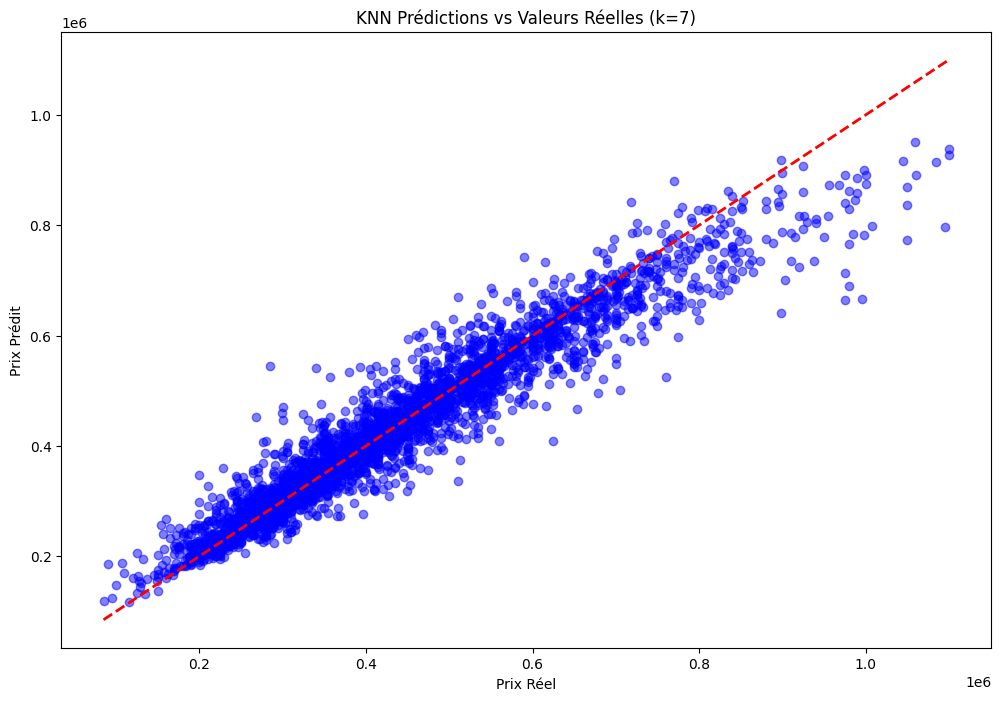

In [68]:
plt.rcParams['figure.figsize'] = (15, 5)

# Graphique des prédictions vs valeurs réelles
plt.figure(figsize=(12, 8))
plt.scatter(y_test_full, final_predictions, alpha=0.5, color='blue')
plt.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--', lw=2)
plt.xlabel('Prix Réel')
plt.ylabel('Prix Prédit')
plt.title(f'KNN Prédictions vs Valeurs Réelles (k={best_k})')
plt.show()

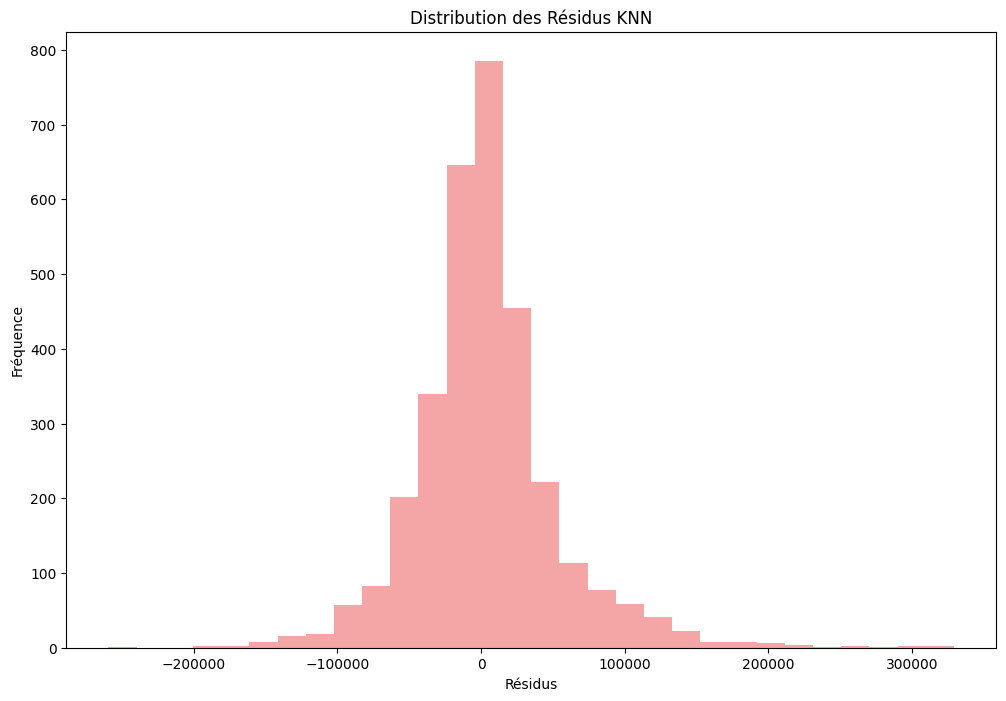

In [69]:
# Distribution des résidus
plt.figure(figsize=(12, 8))
residuals = y_test_full - final_predictions
plt.hist(residuals, bins=30, alpha=0.7, color='lightcoral')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Distribution des Résidus KNN')
plt.show()

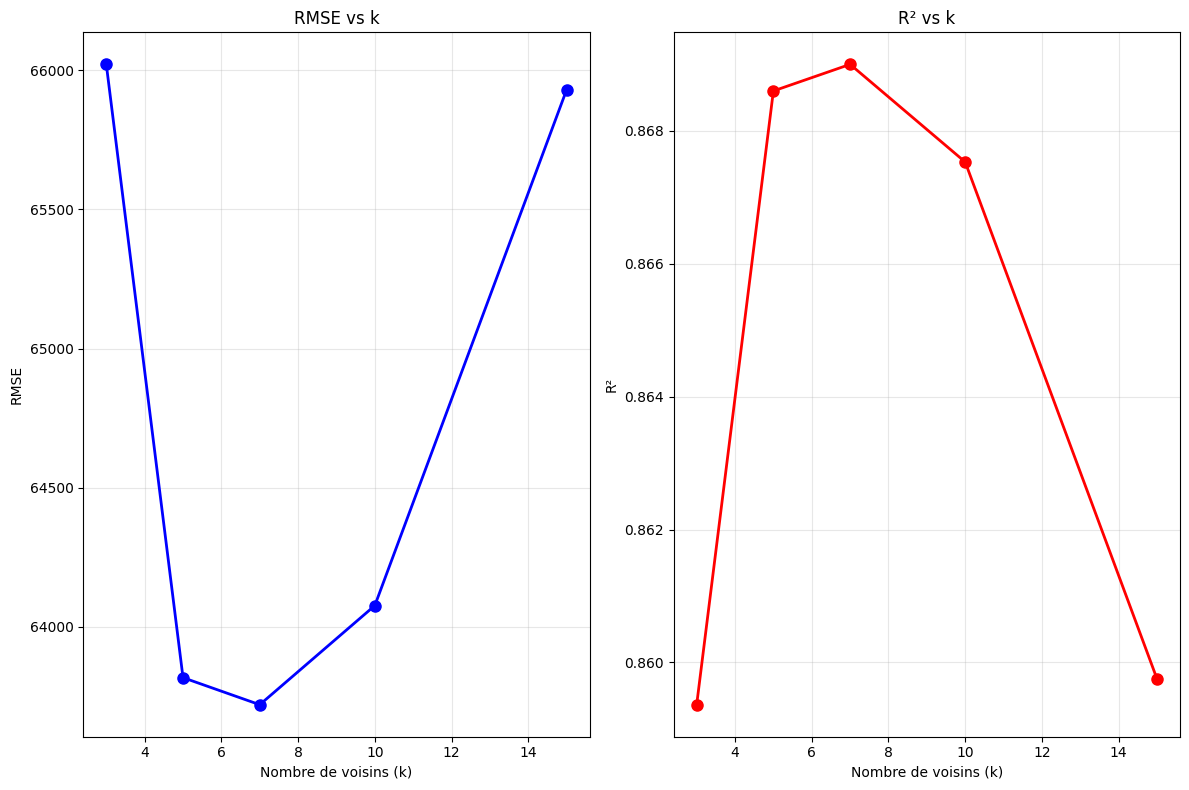

In [70]:
# Performance en fonction de k
plt.figure(figsize=(12, 8))
k_values = list(results.keys())
rmse_values = [results[k]['rmse'] for k in k_values]
r2_values = [results[k]['r2'] for k in k_values]
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('RMSE')
plt.title('RMSE vs k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, r2_values, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

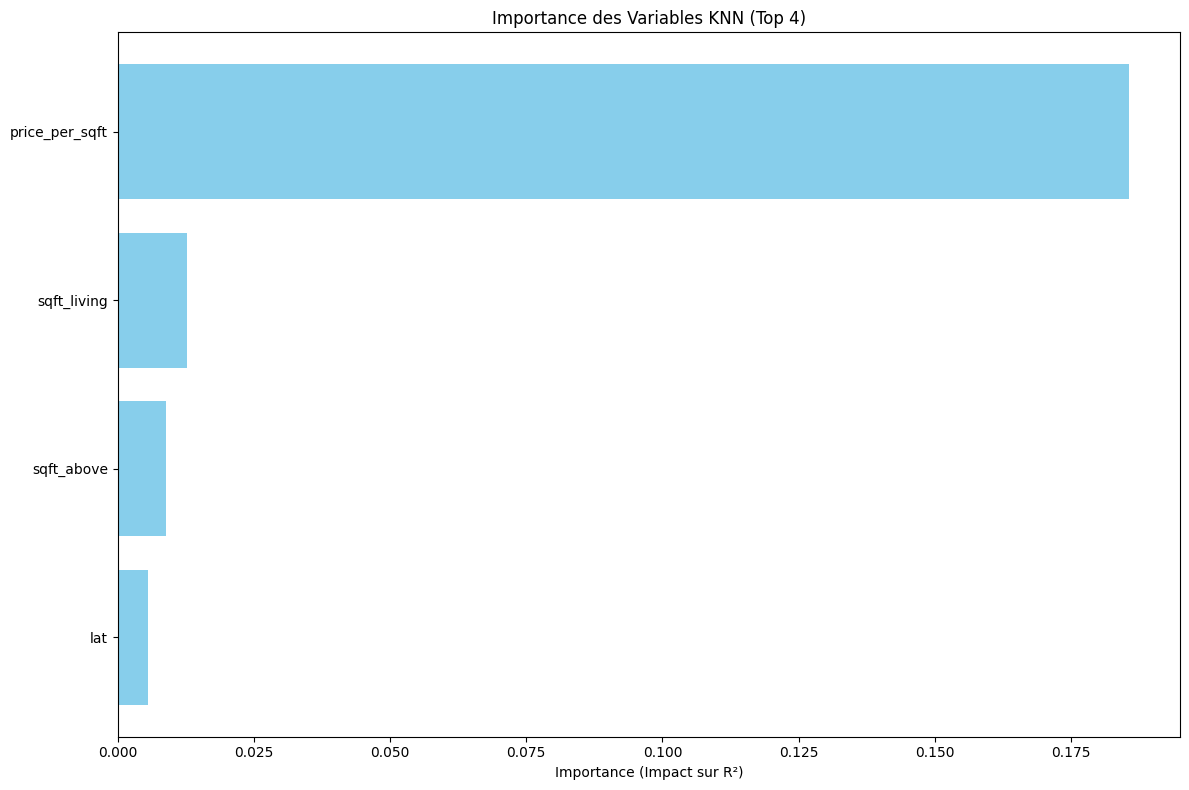

In [72]:
# Importance des variables
plt.figure(figsize=(12, 8))
top_features = feature_importance[:4]
features_names = [f[0] for f in top_features]
importance_values = [f[1] for f in top_features]

plt.barh(range(len(features_names)), importance_values, color='skyblue')
plt.yticks(range(len(features_names)), features_names)
plt.xlabel('Importance (Impact sur R²)')
plt.title('Importance des Variables KNN (Top 4)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#12. COMPARAISON DES PERFORMANCES SELON K

In [73]:
print(f"\n📊 COMPARAISON DES PERFORMANCES SELON K:")
print("="*60)
print(f"{'k':>3} | {'RMSE':>12} | {'R²':>8} | {'MAE':>12}")
print("="*60)
for k in sorted(results.keys()):
    rmse = results[k]['rmse']
    r2 = results[k]['r2']
    mae = results[k]['mae']
    marker = " ⭐" if k == best_k else ""
    print(f"{k:>3} | ${rmse:>11,.0f} | {r2:>7.4f} | ${mae:>11,.0f}{marker}")



📊 COMPARAISON DES PERFORMANCES SELON K:
  k |         RMSE |       R² |          MAE
  3 | $     66,022 |  0.8594 | $     45,607
  5 | $     63,818 |  0.8686 | $     43,887
  7 | $     63,720 |  0.8690 | $     43,935 ⭐
 10 | $     64,077 |  0.8675 | $     44,249
 15 | $     65,930 |  0.8598 | $     45,299


#13. CONCLUSION ET RECOMMANDATIONS

In [74]:
print(f"""
📊 RÉSUMÉ DE LA PERFORMANCE KNN:
   • Le modèle KNN avec k={best_k} atteint un R² de {r2_final:.4f}, expliquant {r2_final*100:.2f}% de la variance
   • RMSE de ${rmse_final:,.0f}, soit une erreur moyenne de {(rmse_final/mean_price)*100:.1f}%
   • Les variables les plus importantes sont: {', '.join([f[0] for f in feature_importance[:3]])}

🔧 OPTIMISATIONS RÉALISÉES POUR KNN:
   • Normalisation stricte des features (critique pour KNN)
   • Suppression des outliers avec seuil plus strict
   • Optimisation du paramètre k par validation croisée
   • Utilisation de la pondération par distance inverse
   • Feature engineering adapté aux distances

⚡ CARACTÉRISTIQUES DU MODÈLE KNN:
   • Modèle non-paramétrique, capture les relations non-linéaires
   • Sensible à la malédiction de la dimensionnalité
   • Performance dépendante de la qualité de la normalisation
   • Temps de prédiction proportionnel à la taille du dataset

🎯 RECOMMANDATIONS:
   • Pour la production: considérer l'indexation spatiale (KD-Tree, Ball-Tree)
   • Surveiller les performances avec l'augmentation des données
   • Évaluer périodiquement le paramètre k optimal
   • Considérer des métriques de distance alternatives selon le contexte
""")



📊 RÉSUMÉ DE LA PERFORMANCE KNN:
   • Le modèle KNN avec k=7 atteint un R² de 0.9176, expliquant 91.76% de la variance
   • RMSE de $49,583, soit une erreur moyenne de 11.4%
   • Les variables les plus importantes sont: price_per_sqft, sqft_living, sqft_above

🔧 OPTIMISATIONS RÉALISÉES POUR KNN:
   • Normalisation stricte des features (critique pour KNN)
   • Suppression des outliers avec seuil plus strict
   • Optimisation du paramètre k par validation croisée
   • Utilisation de la pondération par distance inverse
   • Feature engineering adapté aux distances

⚡ CARACTÉRISTIQUES DU MODÈLE KNN:
   • Modèle non-paramétrique, capture les relations non-linéaires
   • Sensible à la malédiction de la dimensionnalité
   • Performance dépendante de la qualité de la normalisation
   • Temps de prédiction proportionnel à la taille du dataset

🎯 RECOMMANDATIONS:
   • Pour la production: considérer l'indexation spatiale (KD-Tree, Ball-Tree)
   • Surveiller les performances avec l'augmentation de